In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import nengo

In this notebook, we generate a single Ensemble that encodes an SSP.  We then show that we can train up two different decoders from that Ensemble to decode two completely different functions *that have different dimensional input* and still have the output work correctly.  This is because SSPs let you map any input dimensionality into that SSP, and each SSP encoding can have a different set of basis vectors, so there shouldn't be systematic biases from one encoding to the next.

We start by defining our helper functions to make SSPs

In [4]:
# Function to define SSP mapping given A
def ssp_encode(A, x):
    x = np.atleast_2d(x)
    return np.fft.ifft( np.exp( 1.j * A @ x.T), axis=0).real.T

def bind(u, v):
    u = np.atleast_2d(u)
    v = np.atleast_2d(v)
    return np.fft.ifft( np.fft.fft(u, axis=1)*np.fft.fft(v, axis=1), axis=1).real

def invert(phi):
    phi = np.atleast_2d(phi)
    return phi[:,-np.arange(phi.shape[1])]

# Create a random A  matrix

def generate_phase_matrix(d,n):
    A = np.zeros((d, n))

    # Make A martix have conjugate symmetry
    A[0] = 0 
    # Phases between -pi to pi 
    A[1:(d + 1) // 2,:] = 2*np.pi*np.random.rand((d - 1) // 2, n) - np.pi
    A[-1:d // 2:-1] = -A[1:(d + 1) // 2,:]
    if d % 2 == 0:
        A[d // 2] = 0
    return A



In [79]:
import scipy.special
def sparsity_to_x_intercept(d, p):
    sign = 1
    if p > 0.5:
        p = 1.0 - p
        sign = -1
    return sign * np.sqrt(1-scipy.special.betaincinv((d-1)/2.0, 0.5, 2*p))


Now we define our two functions.  The first is $w x + (1-w) y$ and the second is $a + b - ab$.  I chose those pretty arbitraily, and for simplicity they both have 1 output value (although that restriction isn't required -- it just makes it easier to plot)

In [195]:
D = 1024

length_scale = 5

N1 = 3
def func1(x):
    return x[0]*x[1]+(1-x[0])*x[2]
P1 = generate_phase_matrix(D, N1)


N2 = 2
def func2(x):
    return x[0]+x[1]-x[0]*x[1]
P2 = generate_phase_matrix(D, N2)




Now let's randomly generate some sample points for those functions, compute the desired outputs, and the SSPs.

In [196]:
S = 10000
pts1 = nengo.dists.Uniform(0, 1).sample(S, N1)
pts2 = nengo.dists.Uniform(0, 1).sample(S, N2)
target1 = np.array([func1(x) for x in pts1])
target2 = np.array([func2(x) for x in pts2])

pts1_ssp = ssp_encode(P1, pts1*length_scale)
pts2_ssp = ssp_encode(P2, pts2*length_scale)

Here's our Ensemble that we'll be using.  I've set the intercepts so it'll be somewhat sparse (each neuron is active for 10% of the possible input space)  

In [197]:
model = nengo.Network()
with model:
    ens = nengo.Ensemble(n_neurons=3000, dimensions=D,
                         intercepts=nengo.dists.Choice([sparsity_to_x_intercept(D,0.1)]),
                        )
sim = nengo.Simulator(model)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Now we find our decoders.  We do the two functions separately, solving for each one's decoders.

In [198]:
solver = nengo.solvers.LstsqL2()

_, A1 = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=pts1_ssp)
dec1, info1 = solver(A1, target1)

_, A2 = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=pts2_ssp)
dec2, info2 = solver(A2, target2)

Given those decoders, we can see how well the function is approximated.  In addition, we can try applying one function's decoders to the other function's activity patterns.  Ideally, this will produce some random output and not have any systematic relationship across functions.

In [199]:
output11 = A1 @ dec1
output22 = A2 @ dec2

output12 = A1 @ dec2
output21 = A2 @ dec1




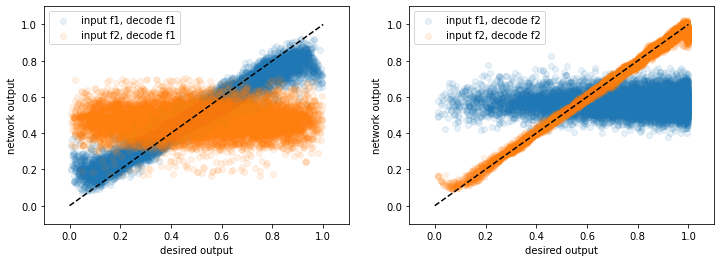

In [200]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.scatter(target1,output11, label='input f1, decode f1', alpha=0.1)
plt.scatter(target1,output21, label='input f2, decode f1', alpha=0.1)
plt.legend()
plt.plot([0,1],[0,1],c='k', ls='--')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.xlabel('desired output')
plt.ylabel('network output')


plt.subplot(1, 2, 2)
plt.scatter(target2,output12, label='input f1, decode f2', alpha=0.1)
plt.scatter(target2,output22, label='input f2, decode f2', alpha=0.1)
plt.legend()
plt.plot([0,1],[0,1],c='k', ls='--')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.xlabel('desired output')
plt.ylabel('network output')
plt.show()



This seems to work as expected.  The first function is decoded less accurately (as it's in a higher dimensionality of the input space), but given inputs for the first function, the first decoder works well while the second decoder gives noise.  And vice versa for the inputs for the second function.

### Multiplexing?

This brings us to a strange possibility -- what if we just feed in inputs from both functions at once?  Ideally, we'd just get a slightly noisier version of what would happen if we tried feeding them in separately.

In [201]:
_, Aboth = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=(pts1_ssp+pts2_ssp)/np.sqrt(2))


In [202]:
outputB2 = Aboth @ dec2
outputB1 = Aboth @ dec1


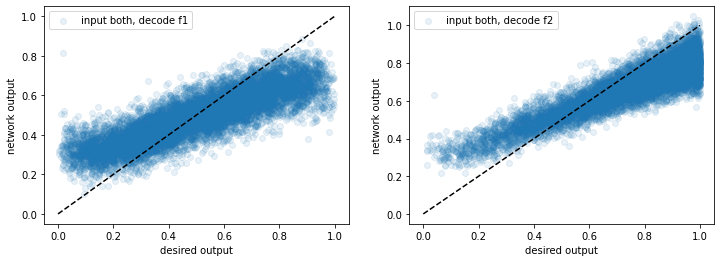

In [203]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.scatter(target1,outputB1, label='input both, decode f1', alpha=0.1)
plt.legend()
plt.plot([0,1],[0,1],c='k', ls='--')
#plt.xlim(-0.1, 1.1)
#plt.ylim(-0.1, 1.1)
plt.xlabel('desired output')
plt.ylabel('network output')


plt.subplot(1, 2, 2)
plt.scatter(target2,outputB2, label='input both, decode f2', alpha=0.1)
plt.legend()
plt.plot([0,1],[0,1],c='k', ls='--')
#plt.xlim(-0.1, 1.1)
#plt.ylim(-0.1, 1.1)
plt.xlabel('desired output')
plt.ylabel('network output')
plt.show()



Definitely noisier, but the functions at least seem to go in the right direction, and this is from decoders that have never been given input that's got both functions at once.  

We can also try solving for decoders for this multiplexed case:

In [204]:
decB1, infoB1 = solver(Aboth, target1)
decB2, infoB2 = solver(Aboth, target2)

outputBB2 = Aboth @ decB2
outputBB1 = Aboth @ decB1


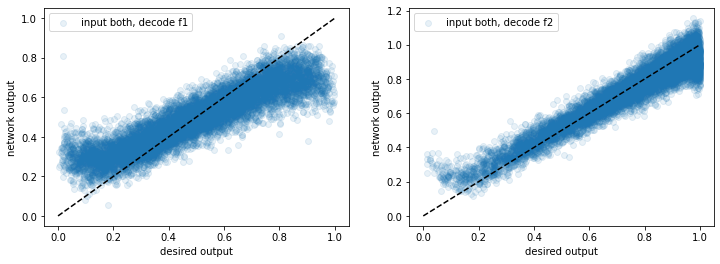

In [205]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.scatter(target1,outputBB1, label='input both, decode f1', alpha=0.1)
plt.legend()
plt.plot([0,1],[0,1],c='k', ls='--')
#plt.xlim(-0.1, 1.1)
#plt.ylim(-0.1, 1.1)
plt.xlabel('desired output')
plt.ylabel('network output')


plt.subplot(1, 2, 2)
plt.scatter(target2,outputBB2, label='input both, decode f2', alpha=0.1)
plt.legend()
plt.plot([0,1],[0,1],c='k', ls='--')
#plt.xlim(-0.1, 1.1)
#plt.ylim(-0.1, 1.1)
plt.xlabel('desired output')
plt.ylabel('network output')
plt.show()



Interesting that this is only a little bit better than the case of the decoders that have never experienced this overlap!

Things to explore:
- SSP dimensionality
- length scale
- sparsity
- number of neurons
- online learning version